## Kaggel: Digit Recognizer(MNIST)  by GPyOpt  
Kaggle Digit recognizer: https://www.kaggle.com/c/digit-recognizer  
GPyOpt: https://github.com/SheffieldML/GPyOpt  

### Score:
* initial_design_numdata=20, max_iter=50,  score: 99.457 (515 mins: NVIDIA GTX1060)

In [1]:
import warnings
warnings.filterwarnings('ignore')

import GPy
import GPyOpt

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Reshape, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.utils import np_utils
import keras

from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

# fix random seed
import tensorflow as tf
import random as rn
import os
os.environ['PYTHONHASHSEED'] = '0'
seed = 123
rn.seed(seed)
np.random.seed(seed)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
from keras import backend as K
tf.set_random_seed(seed)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

Using TensorFlow backend.


## Data preparation: MNIST from Kaggle

In [2]:
train = pd.read_csv('../train.csv')
label = train.label
train = train.drop(['label'], axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(train, label, test_size=0.15, shuffle=True, random_state=seed)
X_train = X_train.values.astype('float32') / 255.0
X_test = X_test.values.astype('float32') / 255.0
Y_train = np_utils.to_categorical(Y_train, 10)
Y_test = np_utils.to_categorical(Y_test, 10)

## Hyperparameters:

In [3]:
params = [
    {'name': 'Dropout_0',        'type': 'continuous',  'domain': (0.0, 0.5)},
    {'name': 'Dropout_1',        'type': 'continuous',  'domain': (0.0, 0.5)},
    {'name': 'Dropout_2',        'type': 'continuous',  'domain': (0.0, 0.5)},
    {'name': 'Dropout_3',        'type': 'continuous',  'domain': (0.0, 0.5)}
    #{'name': 'Dense_0',          'type': 'discrete',    'domain': (128,256, 512)},
    #{'name': 'Dense_1',          'type': 'discrete',    'domain': (64,128, 256)},
    #{'name': 'validation_split', 'type': 'continuous',  'domain': (0.1, 0.3)}
]

## CNN Model:

In [4]:
cnt = 0
def cnn_model(x):
    
    def Param(p_name):
        p_index = [p['name'] for p in params].index(p_name)
        p_type = params[p_index]['type']
        
        if type(x) is np.ndarray:
            if p_type == 'continuous':
                return float(x[:, p_index])
            else:
                return int(x[:, p_index])
        else: # list
            if p_type == 'continuous':
                return float(params[p_index]['domain'])
            else:
                return int(params[p_index]['domain'])
    
    initializer = keras.initializers.glorot_uniform(seed=seed)
    
    model = Sequential() 
    model.add(Reshape((28,28,1), input_shape=(784,)))
        
    model.add(Conv2D(32, (5,5), padding='same', activation='relu', kernel_initializer=initializer))
    model.add(Conv2D(32, (5,5), padding='same', activation='relu', kernel_initializer=initializer))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(Param('Dropout_0'), seed=seed))
    
    model.add(Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer=initializer))
    model.add(Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer=initializer))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(Param('Dropout_1'), seed=seed))

    model.add(Flatten())
    model.add(Dense(256, activation="relu", kernel_initializer=initializer))
    model.add(BatchNormalization())
    model.add(Dropout(Param('Dropout_2'), seed=seed))
    model.add(Dense(128, activation = "relu", kernel_initializer=initializer))
    model.add(BatchNormalization())
    model.add(Dropout(Param('Dropout_3'), seed=seed))
    
    model.add(Dense(10, activation = "softmax", kernel_initializer=initializer))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5,verbose=1, cooldown=1)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')

    hist = model.fit(X_train, Y_train,
                     batch_size=32,
                     epochs=50,
                     verbose=1,
                     shuffle=True,
                     #validation_split=Param('validation_split'),
                     validation_data=(X_test, Y_test),
                     callbacks=[reduce_lr, early_stopping])
    
    loss = hist.history['val_loss'][-1]
    acc = hist.history['val_acc'][-1]
    
    global cnt
    print(cnt, ': Test_loss:', loss, ', Test_acc:', acc)
    print('Model: ', model, '\n\n')
    cnt += 1
    
    return loss, acc, model, hist

## Fitting function:  
return a negative accuracy value  

In [5]:
def f(x):
    loss, acc, model, hist = cnn_model(x)
    return -acc

## Bayesian Optimization:
:model_type: type of model to use as surrogate:
        - 'GP', standard Gaussian process.
        - 'GP_MCMC', Gaussian process with prior in the hyper-parameters.
        - 'sparseGP', sparse Gaussian process.
        - 'warperdGP', warped Gaussian process.
        - 'InputWarpedGP', input warped Gaussian process
        - 'RF', random forest (scikit-learn).  
:acquisition_type: type of acquisition function to use.
        - 'EI', expected improvement.
        - 'EI_MCMC', integrated expected improvement (requires GP_MCMC model).
        - 'MPI', maximum probability of improvement.
        - 'MPI_MCMC', maximum probability of improvement (requires GP_MCMC model).
        - 'LCB', GP-Lower confidence bound.
        - 'LCB_MCMC', integrated GP-Lower confidence bound (requires GP_MCMC model).

In [6]:
opt = GPyOpt.methods.BayesianOptimization(f=f, 
                                          domain=params,
                                          initial_design_numdata = 30,
                                          model_type='GP_MCMC',
                                          acquisition_type='EI_MCMC',
                                          exact_feval=False)
# initial_design_num:30   2,5hrs

Train on 35700 samples, validate on 6300 samples
Epoch 1/50
35700/35700 [==============================] - 13s 366us/step - loss: 0.2172 - acc: 0.9336 - val_loss: 0.0792 - val_acc: 0.9751
Epoch 2/50
35700/35700 [==============================] - 11s 311us/step - loss: 0.0949 - acc: 0.9700 - val_loss: 0.0740 - val_acc: 0.9760
Epoch 3/50
35700/35700 [==============================] - 11s 313us/step - loss: 0.0694 - acc: 0.9788 - val_loss: 0.0515 - val_acc: 0.9848
Epoch 4/50
35700/35700 [==============================] - 11s 315us/step - loss: 0.0597 - acc: 0.9823 - val_loss: 0.0355 - val_acc: 0.9898
Epoch 5/50
35700/35700 [==============================] - 11s 313us/step - loss: 0.0543 - acc: 0.9842 - val_loss: 0.0472 - val_acc: 0.9851
Epoch 6/50
35700/35700 [==============================] - 11s 314us/step - loss: 0.0480 - acc: 0.9857 - val_loss: 0.0282 - val_acc: 0.9908
Epoch 7/50
35700/35700 [==============================] - 11s 313us/step - loss: 0.0421 - acc: 0.9871 - val_loss: 0.0

35700/35700 [==============================] - 11s 313us/step - loss: 0.0047 - acc: 0.9986 - val_loss: 0.0178 - val_acc: 0.9962
Epoch 27/50
35700/35700 [==============================] - 11s 314us/step - loss: 0.0042 - acc: 0.9987 - val_loss: 0.0174 - val_acc: 0.9963

Epoch 00027: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Epoch 28/50
35700/35700 [==============================] - 11s 313us/step - loss: 0.0035 - acc: 0.9992 - val_loss: 0.0173 - val_acc: 0.9965
Epoch 29/50
35700/35700 [==============================] - 11s 313us/step - loss: 0.0038 - acc: 0.9987 - val_loss: 0.0172 - val_acc: 0.9965
Epoch 30/50
35700/35700 [==============================] - 11s 314us/step - loss: 0.0041 - acc: 0.9989 - val_loss: 0.0173 - val_acc: 0.9962

Epoch 00030: ReduceLROnPlateau reducing learning rate to 1e-05.
Epoch 31/50
35700/35700 [==============================] - 11s 314us/step - loss: 0.0039 - acc: 0.9988 - val_loss: 0.0174 - val_acc: 0.9962
Epoch 32/50
35700/35700 [

Epoch 22/50
35700/35700 [==============================] - 11s 320us/step - loss: 0.0071 - acc: 0.9979 - val_loss: 0.0178 - val_acc: 0.9959

Epoch 00022: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Epoch 23/50
35700/35700 [==============================] - 11s 320us/step - loss: 0.0056 - acc: 0.9982 - val_loss: 0.0181 - val_acc: 0.9952
Epoch 00023: early stopping
3 : Test_loss: 0.018103270509453734 , Test_acc: 0.9952380952380953
Model:  <keras.engine.sequential.Sequential object at 0x7fb385b0ca90> 


Train on 35700 samples, validate on 6300 samples
Epoch 1/50
35700/35700 [==============================] - 13s 361us/step - loss: 0.2476 - acc: 0.9233 - val_loss: 0.0558 - val_acc: 0.9833
Epoch 2/50
35700/35700 [==============================] - 12s 324us/step - loss: 0.0950 - acc: 0.9704 - val_loss: 0.0571 - val_acc: 0.9835
Epoch 3/50
35700/35700 [==============================] - 12s 325us/step - loss: 0.0750 - acc: 0.9762 - val_loss: 0.0563 - val_acc: 0.9821

Epoc


Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 8/50
35700/35700 [==============================] - 12s 331us/step - loss: 0.0315 - acc: 0.9904 - val_loss: 0.0222 - val_acc: 0.9927
Epoch 9/50
35700/35700 [==============================] - 12s 330us/step - loss: 0.0270 - acc: 0.9914 - val_loss: 0.0225 - val_acc: 0.9925
Epoch 10/50
35700/35700 [==============================] - 12s 330us/step - loss: 0.0241 - acc: 0.9932 - val_loss: 0.0173 - val_acc: 0.9944
Epoch 11/50
35700/35700 [==============================] - 12s 331us/step - loss: 0.0228 - acc: 0.9931 - val_loss: 0.0178 - val_acc: 0.9938
Epoch 12/50
35700/35700 [==============================] - 12s 330us/step - loss: 0.0245 - acc: 0.9923 - val_loss: 0.0207 - val_acc: 0.9938

Epoch 00012: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 13/50
35700/35700 [==============================] - 12s 331us/step - loss: 0.0170 - acc: 0.9948 - val_loss: 0.0154 - val_acc: 0.9952


35700/35700 [==============================] - 12s 337us/step - loss: 0.0371 - acc: 0.9887 - val_loss: 0.0195 - val_acc: 0.9937
Epoch 6/50
35700/35700 [==============================] - 12s 336us/step - loss: 0.0333 - acc: 0.9896 - val_loss: 0.0255 - val_acc: 0.9932
Epoch 7/50
35700/35700 [==============================] - 12s 336us/step - loss: 0.0305 - acc: 0.9902 - val_loss: 0.0264 - val_acc: 0.9916

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 8/50
35700/35700 [==============================] - 12s 337us/step - loss: 0.0212 - acc: 0.9933 - val_loss: 0.0188 - val_acc: 0.9949
Epoch 9/50
35700/35700 [==============================] - 12s 337us/step - loss: 0.0177 - acc: 0.9947 - val_loss: 0.0202 - val_acc: 0.9941
Epoch 10/50
35700/35700 [==============================] - 12s 338us/step - loss: 0.0164 - acc: 0.9951 - val_loss: 0.0160 - val_acc: 0.9954
Epoch 11/50
35700/35700 [==============================] - 12s 338us/step - loss: 0.0152 - acc:

35700/35700 [==============================] - 12s 343us/step - loss: 0.0086 - acc: 0.9979 - val_loss: 0.0196 - val_acc: 0.9948
Epoch 15/50
35700/35700 [==============================] - 12s 346us/step - loss: 0.0085 - acc: 0.9975 - val_loss: 0.0209 - val_acc: 0.9956

Epoch 00015: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 16/50
35700/35700 [==============================] - 12s 346us/step - loss: 0.0055 - acc: 0.9983 - val_loss: 0.0176 - val_acc: 0.9960
Epoch 17/50
35700/35700 [==============================] - 13s 351us/step - loss: 0.0043 - acc: 0.9989 - val_loss: 0.0190 - val_acc: 0.9952

Epoch 00017: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 18/50
35700/35700 [==============================] - 12s 346us/step - loss: 0.0049 - acc: 0.9984 - val_loss: 0.0177 - val_acc: 0.9960
Epoch 00018: early stopping
10 : Test_loss: 0.01774196404587461 , Test_acc: 0.996031746031746
Model:  <keras.engine.sequential.Sequential object at 0x7

Train on 35700 samples, validate on 6300 samples
Epoch 1/50
35700/35700 [==============================] - 15s 422us/step - loss: 0.1711 - acc: 0.9470 - val_loss: 0.0471 - val_acc: 0.9863
Epoch 2/50
35700/35700 [==============================] - 13s 354us/step - loss: 0.0746 - acc: 0.9776 - val_loss: 0.0416 - val_acc: 0.9873
Epoch 3/50
35700/35700 [==============================] - 13s 353us/step - loss: 0.0575 - acc: 0.9825 - val_loss: 0.0616 - val_acc: 0.9810
Epoch 4/50
35700/35700 [==============================] - 13s 354us/step - loss: 0.0476 - acc: 0.9855 - val_loss: 0.0563 - val_acc: 0.9835

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5/50
35700/35700 [==============================] - 13s 355us/step - loss: 0.0317 - acc: 0.9901 - val_loss: 0.0312 - val_acc: 0.9908
Epoch 6/50
35700/35700 [==============================] - 13s 354us/step - loss: 0.0248 - acc: 0.9927 - val_loss: 0.0219 - val_acc: 0.9932
Epoch 7/50
35700/35700 [============

Epoch 00018: early stopping
15 : Test_loss: 0.021730343739279002 , Test_acc: 0.9952380953137837
Model:  <keras.engine.sequential.Sequential object at 0x7fb34ed86ef0> 


Train on 35700 samples, validate on 6300 samples
Epoch 1/50
35700/35700 [==============================] - 16s 440us/step - loss: 0.2236 - acc: 0.9334 - val_loss: 0.1078 - val_acc: 0.9671
Epoch 2/50
35700/35700 [==============================] - 13s 363us/step - loss: 0.0865 - acc: 0.9739 - val_loss: 0.0515 - val_acc: 0.9844
Epoch 3/50
35700/35700 [==============================] - 13s 363us/step - loss: 0.0664 - acc: 0.9800 - val_loss: 0.0413 - val_acc: 0.9886
Epoch 4/50
35700/35700 [==============================] - 13s 362us/step - loss: 0.0599 - acc: 0.9822 - val_loss: 0.0399 - val_acc: 0.9876
Epoch 5/50
35700/35700 [==============================] - 13s 363us/step - loss: 0.0559 - acc: 0.9829 - val_loss: 0.0330 - val_acc: 0.9914
Epoch 6/50
35700/35700 [==============================] - 13s 363us/step - loss: 0.0452

Epoch 10/50
35700/35700 [==============================] - 13s 371us/step - loss: 0.0226 - acc: 0.9931 - val_loss: 0.0247 - val_acc: 0.9930
Epoch 11/50
35700/35700 [==============================] - 13s 370us/step - loss: 0.0197 - acc: 0.9940 - val_loss: 0.0310 - val_acc: 0.9913

Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 12/50
35700/35700 [==============================] - 13s 370us/step - loss: 0.0155 - acc: 0.9953 - val_loss: 0.0197 - val_acc: 0.9946
Epoch 13/50
35700/35700 [==============================] - 13s 370us/step - loss: 0.0123 - acc: 0.9959 - val_loss: 0.0212 - val_acc: 0.9948
Epoch 14/50
35700/35700 [==============================] - 13s 369us/step - loss: 0.0104 - acc: 0.9970 - val_loss: 0.0188 - val_acc: 0.9948
Epoch 15/50
35700/35700 [==============================] - 13s 369us/step - loss: 0.0101 - acc: 0.9969 - val_loss: 0.0186 - val_acc: 0.9959
Epoch 16/50
35700/35700 [==============================] - 13s 372us/step - los

35700/35700 [==============================] - 14s 399us/step - loss: 0.0055 - acc: 0.9983 - val_loss: 0.0253 - val_acc: 0.9941

Epoch 00016: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 17/50
35700/35700 [==============================] - 14s 378us/step - loss: 0.0040 - acc: 0.9988 - val_loss: 0.0187 - val_acc: 0.9959
Epoch 18/50
35700/35700 [==============================] - 13s 377us/step - loss: 0.0029 - acc: 0.9993 - val_loss: 0.0172 - val_acc: 0.9963

Epoch 00018: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 19/50
35700/35700 [==============================] - 13s 377us/step - loss: 0.0032 - acc: 0.9990 - val_loss: 0.0163 - val_acc: 0.9960
Epoch 20/50
35700/35700 [==============================] - 13s 377us/step - loss: 0.0026 - acc: 0.9994 - val_loss: 0.0161 - val_acc: 0.9960
Epoch 21/50
35700/35700 [==============================] - 13s 374us/step - loss: 0.0024 - acc: 0.9992 - val_loss: 0.0156 - val_acc: 0.9962
Epoch 22/50

Epoch 00040: early stopping
21 : Test_loss: 0.015097631067081469 , Test_acc: 0.9955555555555555
Model:  <keras.engine.sequential.Sequential object at 0x7fb347744518> 


Train on 35700 samples, validate on 6300 samples
Epoch 1/50
35700/35700 [==============================] - 17s 482us/step - loss: 0.2014 - acc: 0.9366 - val_loss: 0.0566 - val_acc: 0.9824
Epoch 2/50
35700/35700 [==============================] - 14s 385us/step - loss: 0.0850 - acc: 0.9744 - val_loss: 0.0489 - val_acc: 0.9856
Epoch 3/50
35700/35700 [==============================] - 14s 383us/step - loss: 0.0667 - acc: 0.9790 - val_loss: 0.0861 - val_acc: 0.9721
Epoch 4/50
35700/35700 [==============================] - 14s 383us/step - loss: 0.0593 - acc: 0.9818 - val_loss: 0.0448 - val_acc: 0.9846
Epoch 5/50
35700/35700 [==============================] - 14s 382us/step - loss: 0.0507 - acc: 0.9847 - val_loss: 0.0377 - val_acc: 0.9886
Epoch 6/50
35700/35700 [==============================] - 14s 382us/step - loss: 0.0455

35700/35700 [==============================] - 14s 388us/step - loss: 0.0052 - acc: 0.9987 - val_loss: 0.0151 - val_acc: 0.9965
Epoch 00026: early stopping
23 : Test_loss: 0.015138333909791461 , Test_acc: 0.9965079365079365
Model:  <keras.engine.sequential.Sequential object at 0x7fb3432b9240> 


Train on 35700 samples, validate on 6300 samples
Epoch 1/50
35700/35700 [==============================] - 18s 495us/step - loss: 0.2305 - acc: 0.9300 - val_loss: 0.0676 - val_acc: 0.9775
Epoch 2/50
35700/35700 [==============================] - 14s 389us/step - loss: 0.0923 - acc: 0.9723 - val_loss: 0.0502 - val_acc: 0.9843
Epoch 3/50
35700/35700 [==============================] - 14s 391us/step - loss: 0.0704 - acc: 0.9792 - val_loss: 0.0342 - val_acc: 0.9895
Epoch 4/50
35700/35700 [==============================] - 14s 389us/step - loss: 0.0667 - acc: 0.9797 - val_loss: 0.0507 - val_acc: 0.9846
Epoch 5/50
35700/35700 [==============================] - 14s 389us/step - loss: 0.0558 - acc: 0.9

35700/35700 [==============================] - 14s 394us/step - loss: 0.0032 - acc: 0.9991 - val_loss: 0.0183 - val_acc: 0.9957
Epoch 00025: early stopping
25 : Test_loss: 0.0182860114392985 , Test_acc: 0.9957142857142857
Model:  <keras.engine.sequential.Sequential object at 0x7fb3413f6a20> 


Train on 35700 samples, validate on 6300 samples
Epoch 1/50
35700/35700 [==============================] - 18s 510us/step - loss: 0.1927 - acc: 0.9404 - val_loss: 0.0643 - val_acc: 0.9814
Epoch 2/50
35700/35700 [==============================] - 14s 398us/step - loss: 0.0756 - acc: 0.9770 - val_loss: 0.0453 - val_acc: 0.9862
Epoch 3/50
35700/35700 [==============================] - 14s 398us/step - loss: 0.0612 - acc: 0.9821 - val_loss: 0.0473 - val_acc: 0.9862
Epoch 4/50
35700/35700 [==============================] - 14s 398us/step - loss: 0.0576 - acc: 0.9825 - val_loss: 0.0438 - val_acc: 0.9873
Epoch 5/50
35700/35700 [==============================] - 14s 397us/step - loss: 0.0457 - acc: 0.986

35700/35700 [==============================] - 14s 405us/step - loss: 0.0507 - acc: 0.9832 - val_loss: 0.0472 - val_acc: 0.9852
Epoch 5/50
35700/35700 [==============================] - 15s 407us/step - loss: 0.0448 - acc: 0.9857 - val_loss: 0.0388 - val_acc: 0.9892
Epoch 6/50
35700/35700 [==============================] - 14s 406us/step - loss: 0.0380 - acc: 0.9878 - val_loss: 0.0328 - val_acc: 0.9908
Epoch 7/50
35700/35700 [==============================] - 14s 405us/step - loss: 0.0354 - acc: 0.9894 - val_loss: 0.0348 - val_acc: 0.9898
Epoch 8/50
35700/35700 [==============================] - 15s 406us/step - loss: 0.0326 - acc: 0.9902 - val_loss: 0.0446 - val_acc: 0.9852

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 9/50
35700/35700 [==============================] - 14s 404us/step - loss: 0.0188 - acc: 0.9942 - val_loss: 0.0220 - val_acc: 0.9932
Epoch 10/50
35700/35700 [==============================] - 14s 404us/step - loss: 0.0169 - acc: 

In [7]:
cnt = 0
opt.run_optimization(max_iter=100)
# max_iter: 50 ,7hrs

reconstraining parameters GP_regression.rbf
reconstraining parameters GP_regression.Gaussian_noise.variance


Train on 35700 samples, validate on 6300 samples
Epoch 1/50
35700/35700 [==============================] - 19s 540us/step - loss: 0.3128 - acc: 0.9039 - val_loss: 0.0633 - val_acc: 0.9792
Epoch 2/50
35700/35700 [==============================] - 15s 415us/step - loss: 0.1123 - acc: 0.9673 - val_loss: 0.0434 - val_acc: 0.9868
Epoch 3/50
35700/35700 [==============================] - 15s 415us/step - loss: 0.0932 - acc: 0.9719 - val_loss: 0.0430 - val_acc: 0.9857
Epoch 4/50
35700/35700 [==============================] - 15s 413us/step - loss: 0.0781 - acc: 0.9763 - val_loss: 0.0491 - val_acc: 0.9852
Epoch 5/50
35700/35700 [==============================] - 15s 416us/step - loss: 0.0632 - acc: 0.9810 - val_loss: 0.0350 - val_acc: 0.9894
Epoch 6/50
35700/35700 [==============================] - 15s 414us/step - loss: 0.0617 - acc: 0.9820 - val_loss: 0.0418 - val_acc: 0.9883
Epoch 7/50
35700/35700 [==============================] - 15s 414us/step - loss: 0.0539 - acc: 0.9836 - val_loss: 0.0

35700/35700 [==============================] - 15s 417us/step - loss: 0.0582 - acc: 0.9827 - val_loss: 0.0325 - val_acc: 0.9898
Epoch 7/50
35700/35700 [==============================] - 15s 419us/step - loss: 0.0518 - acc: 0.9839 - val_loss: 0.0410 - val_acc: 0.9897

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 8/50
35700/35700 [==============================] - 15s 417us/step - loss: 0.0363 - acc: 0.9892 - val_loss: 0.0278 - val_acc: 0.9917
Epoch 9/50
35700/35700 [==============================] - 15s 417us/step - loss: 0.0305 - acc: 0.9906 - val_loss: 0.0234 - val_acc: 0.9932
Epoch 10/50
35700/35700 [==============================] - 15s 417us/step - loss: 0.0303 - acc: 0.9908 - val_loss: 0.0192 - val_acc: 0.9943
Epoch 11/50
35700/35700 [==============================] - 15s 418us/step - loss: 0.0267 - acc: 0.9919 - val_loss: 0.0203 - val_acc: 0.9944
Epoch 12/50
35700/35700 [==============================] - 15s 417us/step - loss: 0.0269 - acc


Epoch 00031: ReduceLROnPlateau reducing learning rate to 1e-05.
Epoch 32/50
35700/35700 [==============================] - 15s 424us/step - loss: 0.0103 - acc: 0.9973 - val_loss: 0.0181 - val_acc: 0.9959
Epoch 00032: early stopping
3 : Test_loss: 0.018061178996299748 , Test_acc: 0.9958730158730159
Model:  <keras.engine.sequential.Sequential object at 0x7fb3170f8b70> 


Train on 35700 samples, validate on 6300 samples
Epoch 1/50
35700/35700 [==============================] - 20s 569us/step - loss: 0.2851 - acc: 0.9132 - val_loss: 0.0727 - val_acc: 0.9770
Epoch 2/50
35700/35700 [==============================] - 15s 427us/step - loss: 0.1039 - acc: 0.9689 - val_loss: 0.0835 - val_acc: 0.9729
Epoch 3/50
35700/35700 [==============================] - 15s 429us/step - loss: 0.0827 - acc: 0.9751 - val_loss: 0.0667 - val_acc: 0.9786
Epoch 4/50
35700/35700 [==============================] - 15s 429us/step - loss: 0.0704 - acc: 0.9792 - val_loss: 0.0422 - val_acc: 0.9875
Epoch 5/50
35700/35700

35700/35700 [==============================] - 16s 441us/step - loss: 0.0491 - acc: 0.9854 - val_loss: 0.0270 - val_acc: 0.9913
Epoch 8/50
35700/35700 [==============================] - 16s 439us/step - loss: 0.0442 - acc: 0.9870 - val_loss: 0.0292 - val_acc: 0.9916
Epoch 9/50
35700/35700 [==============================] - 16s 439us/step - loss: 0.0422 - acc: 0.9868 - val_loss: 0.0276 - val_acc: 0.9910

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 10/50
35700/35700 [==============================] - 16s 439us/step - loss: 0.0270 - acc: 0.9918 - val_loss: 0.0226 - val_acc: 0.9946
Epoch 11/50
35700/35700 [==============================] - 16s 437us/step - loss: 0.0248 - acc: 0.9929 - val_loss: 0.0259 - val_acc: 0.9941
Epoch 12/50
35700/35700 [==============================] - 16s 439us/step - loss: 0.0222 - acc: 0.9931 - val_loss: 0.0234 - val_acc: 0.9937

Epoch 00012: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 13/50


Train on 35700 samples, validate on 6300 samples
Epoch 1/50
35700/35700 [==============================] - 21s 596us/step - loss: 0.2290 - acc: 0.9288 - val_loss: 0.0767 - val_acc: 0.9762
Epoch 2/50
35700/35700 [==============================] - 16s 441us/step - loss: 0.0913 - acc: 0.9720 - val_loss: 0.0610 - val_acc: 0.9821
Epoch 3/50
35700/35700 [==============================] - 16s 440us/step - loss: 0.0713 - acc: 0.9777 - val_loss: 0.0565 - val_acc: 0.9829
Epoch 4/50
35700/35700 [==============================] - 16s 444us/step - loss: 0.0637 - acc: 0.9804 - val_loss: 0.0380 - val_acc: 0.9883
Epoch 5/50
35700/35700 [==============================] - 16s 443us/step - loss: 0.0534 - acc: 0.9831 - val_loss: 0.0412 - val_acc: 0.9870
Epoch 6/50
35700/35700 [==============================] - 16s 442us/step - loss: 0.0490 - acc: 0.9848 - val_loss: 0.0325 - val_acc: 0.9889
Epoch 7/50
35700/35700 [==============================] - 16s 442us/step - loss: 0.0456 - acc: 0.9857 - val_loss: 0.0

Epoch 3/50
35700/35700 [==============================] - 16s 450us/step - loss: 0.0884 - acc: 0.9741 - val_loss: 0.0353 - val_acc: 0.9897
Epoch 4/50
35700/35700 [==============================] - 16s 450us/step - loss: 0.0780 - acc: 0.9765 - val_loss: 0.0476 - val_acc: 0.9862
Epoch 5/50
35700/35700 [==============================] - 16s 449us/step - loss: 0.0696 - acc: 0.9788 - val_loss: 0.0338 - val_acc: 0.9903
Epoch 6/50
35700/35700 [==============================] - 16s 450us/step - loss: 0.0612 - acc: 0.9814 - val_loss: 0.0339 - val_acc: 0.9897
Epoch 7/50
35700/35700 [==============================] - 16s 449us/step - loss: 0.0555 - acc: 0.9837 - val_loss: 0.0423 - val_acc: 0.9892

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 8/50
35700/35700 [==============================] - 16s 450us/step - loss: 0.0400 - acc: 0.9882 - val_loss: 0.0267 - val_acc: 0.9922
Epoch 9/50
35700/35700 [==============================] - 16s 449us/step - loss: 0.03

35700/35700 [==============================] - 16s 454us/step - loss: 0.0234 - acc: 0.9927 - val_loss: 0.0298 - val_acc: 0.9910
Epoch 10/50
35700/35700 [==============================] - 16s 453us/step - loss: 0.0225 - acc: 0.9929 - val_loss: 0.0233 - val_acc: 0.9938

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 11/50
35700/35700 [==============================] - 16s 455us/step - loss: 0.0151 - acc: 0.9949 - val_loss: 0.0182 - val_acc: 0.9951
Epoch 12/50
35700/35700 [==============================] - 16s 453us/step - loss: 0.0117 - acc: 0.9964 - val_loss: 0.0206 - val_acc: 0.9941
Epoch 13/50
35700/35700 [==============================] - 16s 455us/step - loss: 0.0105 - acc: 0.9968 - val_loss: 0.0171 - val_acc: 0.9952
Epoch 14/50
35700/35700 [==============================] - 16s 453us/step - loss: 0.0099 - acc: 0.9968 - val_loss: 0.0195 - val_acc: 0.9946
Epoch 15/50
35700/35700 [==============================] - 16s 453us/step - loss: 0.0106 - 

35700/35700 [==============================] - 17s 467us/step - loss: 0.0105 - acc: 0.9971 - val_loss: 0.0190 - val_acc: 0.9952
Epoch 19/50
35700/35700 [==============================] - 17s 467us/step - loss: 0.0090 - acc: 0.9973 - val_loss: 0.0184 - val_acc: 0.9957

Epoch 00019: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 20/50
35700/35700 [==============================] - 17s 465us/step - loss: 0.0083 - acc: 0.9973 - val_loss: 0.0165 - val_acc: 0.9959
Epoch 21/50
35700/35700 [==============================] - 17s 467us/step - loss: 0.0073 - acc: 0.9978 - val_loss: 0.0163 - val_acc: 0.9956
Epoch 22/50
35700/35700 [==============================] - 17s 466us/step - loss: 0.0069 - acc: 0.9981 - val_loss: 0.0169 - val_acc: 0.9962
Epoch 23/50
35700/35700 [==============================] - 17s 466us/step - loss: 0.0056 - acc: 0.9983 - val_loss: 0.0178 - val_acc: 0.9957

Epoch 00023: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 24/50

35700/35700 [==============================] - 17s 473us/step - loss: 0.0076 - acc: 0.9979 - val_loss: 0.0167 - val_acc: 0.9954
Epoch 19/50
35700/35700 [==============================] - 17s 471us/step - loss: 0.0084 - acc: 0.9975 - val_loss: 0.0162 - val_acc: 0.9954
Epoch 20/50
35700/35700 [==============================] - 17s 471us/step - loss: 0.0073 - acc: 0.9979 - val_loss: 0.0153 - val_acc: 0.9954
Epoch 21/50
35700/35700 [==============================] - 17s 472us/step - loss: 0.0085 - acc: 0.9973 - val_loss: 0.0160 - val_acc: 0.9960
Epoch 22/50
35700/35700 [==============================] - 17s 473us/step - loss: 0.0074 - acc: 0.9976 - val_loss: 0.0164 - val_acc: 0.9959

Epoch 00022: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Epoch 23/50
35700/35700 [==============================] - 17s 472us/step - loss: 0.0074 - acc: 0.9978 - val_loss: 0.0166 - val_acc: 0.9956
Epoch 24/50
35700/35700 [==============================] - 17s 471us/step - loss: 0.0053 - 

Epoch 3/50
35700/35700 [==============================] - 17s 479us/step - loss: 0.0945 - acc: 0.9711 - val_loss: 0.0452 - val_acc: 0.9852
Epoch 4/50
35700/35700 [==============================] - 17s 479us/step - loss: 0.0772 - acc: 0.9766 - val_loss: 0.0420 - val_acc: 0.9873
Epoch 5/50
35700/35700 [==============================] - 17s 477us/step - loss: 0.0716 - acc: 0.9780 - val_loss: 0.0337 - val_acc: 0.9902
Epoch 6/50
35700/35700 [==============================] - 17s 478us/step - loss: 0.0614 - acc: 0.9817 - val_loss: 0.0322 - val_acc: 0.9902
Epoch 7/50
35700/35700 [==============================] - 17s 478us/step - loss: 0.0572 - acc: 0.9839 - val_loss: 0.0371 - val_acc: 0.9876
Epoch 8/50
35700/35700 [==============================] - 17s 478us/step - loss: 0.0541 - acc: 0.9840 - val_loss: 0.0298 - val_acc: 0.9903
Epoch 9/50
35700/35700 [==============================] - 17s 477us/step - loss: 0.0467 - acc: 0.9862 - val_loss: 0.0250 - val_acc: 0.9927
Epoch 10/50
35700/35700 [==

Epoch 15/50
35700/35700 [==============================] - 17s 490us/step - loss: 0.0183 - acc: 0.9948 - val_loss: 0.0210 - val_acc: 0.9938

Epoch 00015: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 16/50
35700/35700 [==============================] - 17s 488us/step - loss: 0.0142 - acc: 0.9959 - val_loss: 0.0178 - val_acc: 0.9941
Epoch 17/50
35700/35700 [==============================] - 17s 489us/step - loss: 0.0130 - acc: 0.9960 - val_loss: 0.0168 - val_acc: 0.9948
Epoch 18/50
35700/35700 [==============================] - 18s 490us/step - loss: 0.0105 - acc: 0.9966 - val_loss: 0.0198 - val_acc: 0.9938
Epoch 19/50
35700/35700 [==============================] - 17s 488us/step - loss: 0.0085 - acc: 0.9975 - val_loss: 0.0175 - val_acc: 0.9944

Epoch 00019: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 20/50
35700/35700 [==============================] - 18s 491us/step - loss: 0.0090 - acc: 0.9971 - val_loss: 0.0148 - val_acc: 0.995

35700/35700 [==============================] - 18s 499us/step - loss: 0.0120 - acc: 0.9966 - val_loss: 0.0153 - val_acc: 0.9951
Epoch 12/50
35700/35700 [==============================] - 18s 497us/step - loss: 0.0099 - acc: 0.9971 - val_loss: 0.0156 - val_acc: 0.9952
Epoch 13/50
35700/35700 [==============================] - 18s 499us/step - loss: 0.0089 - acc: 0.9973 - val_loss: 0.0174 - val_acc: 0.9957

Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 14/50
35700/35700 [==============================] - 18s 495us/step - loss: 0.0068 - acc: 0.9979 - val_loss: 0.0153 - val_acc: 0.9948
Epoch 15/50
35700/35700 [==============================] - 18s 498us/step - loss: 0.0053 - acc: 0.9983 - val_loss: 0.0141 - val_acc: 0.9956
Epoch 16/50
35700/35700 [==============================] - 18s 499us/step - loss: 0.0058 - acc: 0.9983 - val_loss: 0.0151 - val_acc: 0.9962
Epoch 17/50
35700/35700 [==============================] - 18s 497us/step - loss: 0.0046 - 

Epoch 00019: early stopping
25 : Test_loss: 0.015954205762079385 , Test_acc: 0.9952380952380953
Model:  <keras.engine.sequential.Sequential object at 0x7fb2f9ced780> 


Train on 35700 samples, validate on 6300 samples
Epoch 1/50
35700/35700 [==============================] - 27s 744us/step - loss: 0.2741 - acc: 0.9176 - val_loss: 0.0934 - val_acc: 0.9692
Epoch 2/50
35700/35700 [==============================] - 18s 512us/step - loss: 0.1034 - acc: 0.9687 - val_loss: 0.0488 - val_acc: 0.9833
Epoch 3/50
35700/35700 [==============================] - 18s 513us/step - loss: 0.0844 - acc: 0.9738 - val_loss: 0.0445 - val_acc: 0.9859
Epoch 4/50
35700/35700 [==============================] - 18s 509us/step - loss: 0.0711 - acc: 0.9790 - val_loss: 0.0382 - val_acc: 0.9883
Epoch 5/50
35700/35700 [==============================] - 18s 508us/step - loss: 0.0592 - acc: 0.9824 - val_loss: 0.0356 - val_acc: 0.9892
Epoch 6/50
35700/35700 [==============================] - 18s 508us/step - loss: 0.0578

Train on 35700 samples, validate on 6300 samples
Epoch 1/50
35700/35700 [==============================] - 27s 759us/step - loss: 0.2707 - acc: 0.9184 - val_loss: 0.0643 - val_acc: 0.9802
Epoch 2/50
35700/35700 [==============================] - 19s 523us/step - loss: 0.0986 - acc: 0.9703 - val_loss: 0.0598 - val_acc: 0.9821
Epoch 3/50
35700/35700 [==============================] - 19s 522us/step - loss: 0.0823 - acc: 0.9744 - val_loss: 0.0489 - val_acc: 0.9854
Epoch 4/50
35700/35700 [==============================] - 19s 521us/step - loss: 0.0655 - acc: 0.9796 - val_loss: 0.0462 - val_acc: 0.9843
Epoch 5/50
35700/35700 [==============================] - 19s 521us/step - loss: 0.0689 - acc: 0.9791 - val_loss: 0.0393 - val_acc: 0.9868
Epoch 6/50
35700/35700 [==============================] - 19s 519us/step - loss: 0.0555 - acc: 0.9845 - val_loss: 0.0374 - val_acc: 0.9895
Epoch 7/50
35700/35700 [==============================] - 18s 517us/step - loss: 0.0524 - acc: 0.9841 - val_loss: 0.0

35700/35700 [==============================] - 18s 517us/step - loss: 0.0063 - acc: 0.9983 - val_loss: 0.0184 - val_acc: 0.9956
Epoch 28/50
35700/35700 [==============================] - 18s 513us/step - loss: 0.0052 - acc: 0.9985 - val_loss: 0.0174 - val_acc: 0.9956
Epoch 29/50
35700/35700 [==============================] - 18s 513us/step - loss: 0.0056 - acc: 0.9982 - val_loss: 0.0179 - val_acc: 0.9951
Epoch 30/50
35700/35700 [==============================] - 18s 515us/step - loss: 0.0046 - acc: 0.9985 - val_loss: 0.0176 - val_acc: 0.9957

Epoch 00030: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Epoch 31/50
35700/35700 [==============================] - 18s 517us/step - loss: 0.0050 - acc: 0.9986 - val_loss: 0.0173 - val_acc: 0.9957
Epoch 32/50
35700/35700 [==============================] - 19s 519us/step - loss: 0.0053 - acc: 0.9984 - val_loss: 0.0172 - val_acc: 0.9959
Epoch 33/50
35700/35700 [==============================] - 19s 521us/step - loss: 0.0051 -

35700/35700 [==============================] - 19s 522us/step - loss: 0.0147 - acc: 0.9956 - val_loss: 0.0175 - val_acc: 0.9941

Epoch 00016: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 17/50
35700/35700 [==============================] - 19s 524us/step - loss: 0.0125 - acc: 0.9961 - val_loss: 0.0157 - val_acc: 0.9949
Epoch 18/50
35700/35700 [==============================] - 19s 523us/step - loss: 0.0101 - acc: 0.9970 - val_loss: 0.0178 - val_acc: 0.9943

Epoch 00018: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 19/50
35700/35700 [==============================] - 19s 523us/step - loss: 0.0097 - acc: 0.9968 - val_loss: 0.0168 - val_acc: 0.9952
Epoch 00019: early stopping
31 : Test_loss: 0.016771756042234343 , Test_acc: 0.9952380952380953
Model:  <keras.engine.sequential.Sequential object at 0x7fb2f1f3a668> 


Train on 35700 samples, validate on 6300 samples
Epoch 1/50
35700/35700 [==============================] - 28s 795us/step 

35700/35700 [==============================] - 19s 529us/step - loss: 0.0055 - acc: 0.9983 - val_loss: 0.0167 - val_acc: 0.9956
Epoch 25/50
35700/35700 [==============================] - 19s 527us/step - loss: 0.0060 - acc: 0.9984 - val_loss: 0.0167 - val_acc: 0.9957

Epoch 00025: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Epoch 26/50
35700/35700 [==============================] - 19s 529us/step - loss: 0.0049 - acc: 0.9985 - val_loss: 0.0167 - val_acc: 0.9957
Epoch 27/50
35700/35700 [==============================] - 19s 527us/step - loss: 0.0047 - acc: 0.9983 - val_loss: 0.0170 - val_acc: 0.9957

Epoch 00027: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Epoch 00027: early stopping
33 : Test_loss: 0.016984369532456474 , Test_acc: 0.9957142857142857
Model:  <keras.engine.sequential.Sequential object at 0x7fb2ef388b70> 


Train on 35700 samples, validate on 6300 samples
Epoch 1/50
35700/35700 [==============================] - 29s 813us/ste

35700/35700 [==============================] - 20s 561us/step - loss: 0.0852 - acc: 0.9752 - val_loss: 0.0485 - val_acc: 0.9860
Epoch 4/50
35700/35700 [==============================] - 20s 573us/step - loss: 0.0698 - acc: 0.9783 - val_loss: 0.0436 - val_acc: 0.9870
Epoch 5/50
35700/35700 [==============================] - 19s 540us/step - loss: 0.0626 - acc: 0.9815 - val_loss: 0.0470 - val_acc: 0.9851
Epoch 6/50
35700/35700 [==============================] - 19s 539us/step - loss: 0.0597 - acc: 0.9822 - val_loss: 0.0435 - val_acc: 0.9854
Epoch 7/50
35700/35700 [==============================] - 19s 543us/step - loss: 0.0514 - acc: 0.9841 - val_loss: 0.0470 - val_acc: 0.9852
Epoch 8/50
35700/35700 [==============================] - 19s 541us/step - loss: 0.0479 - acc: 0.9850 - val_loss: 0.0248 - val_acc: 0.9917
Epoch 9/50
35700/35700 [==============================] - 19s 541us/step - loss: 0.0456 - acc: 0.9867 - val_loss: 0.0340 - val_acc: 0.9902
Epoch 10/50
35700/35700 [=============


Epoch 00023: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Epoch 24/50
35700/35700 [==============================] - 20s 547us/step - loss: 0.0085 - acc: 0.9975 - val_loss: 0.0171 - val_acc: 0.9960
Epoch 00024: early stopping
37 : Test_loss: 0.01709433980251474 , Test_acc: 0.996031746031746
Model:  <keras.engine.sequential.Sequential object at 0x7fb2e993b940> 


Train on 35700 samples, validate on 6300 samples
Epoch 1/50
35700/35700 [==============================] - 31s 862us/step - loss: 0.2816 - acc: 0.9130 - val_loss: 0.0565 - val_acc: 0.9825
Epoch 2/50
35700/35700 [==============================] - 21s 574us/step - loss: 0.1044 - acc: 0.9686 - val_loss: 0.0514 - val_acc: 0.9844
Epoch 3/50
35700/35700 [==============================] - 20s 566us/step - loss: 0.0868 - acc: 0.9737 - val_loss: 0.0388 - val_acc: 0.9871
Epoch 4/50
35700/35700 [==============================] - 20s 565us/step - loss: 0.0721 - acc: 0.9778 - val_loss: 0.0464 - val_acc: 0.9852
Epoch 5

35700/35700 [==============================] - 21s 581us/step - loss: 0.0439 - acc: 0.9873 - val_loss: 0.0352 - val_acc: 0.9889
Epoch 7/50
35700/35700 [==============================] - 21s 584us/step - loss: 0.0380 - acc: 0.9887 - val_loss: 0.0247 - val_acc: 0.9927
Epoch 8/50
35700/35700 [==============================] - 21s 584us/step - loss: 0.0339 - acc: 0.9895 - val_loss: 0.0261 - val_acc: 0.9917
Epoch 9/50
35700/35700 [==============================] - 21s 579us/step - loss: 0.0323 - acc: 0.9901 - val_loss: 0.0262 - val_acc: 0.9927

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 10/50
35700/35700 [==============================] - 21s 579us/step - loss: 0.0262 - acc: 0.9921 - val_loss: 0.0213 - val_acc: 0.9938
Epoch 11/50
35700/35700 [==============================] - 21s 595us/step - loss: 0.0219 - acc: 0.9932 - val_loss: 0.0201 - val_acc: 0.9940
Epoch 12/50
35700/35700 [==============================] - 21s 594us/step - loss: 0.0181 - acc

35700/35700 [==============================] - 21s 589us/step - loss: 0.0538 - acc: 0.9838 - val_loss: 0.0399 - val_acc: 0.9883

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 8/50
35700/35700 [==============================] - 21s 595us/step - loss: 0.0372 - acc: 0.9889 - val_loss: 0.0282 - val_acc: 0.9925
Epoch 9/50
35700/35700 [==============================] - 21s 591us/step - loss: 0.0332 - acc: 0.9900 - val_loss: 0.0250 - val_acc: 0.9933
Epoch 10/50
35700/35700 [==============================] - 21s 593us/step - loss: 0.0295 - acc: 0.9914 - val_loss: 0.0224 - val_acc: 0.9932
Epoch 11/50
35700/35700 [==============================] - 21s 594us/step - loss: 0.0260 - acc: 0.9924 - val_loss: 0.0237 - val_acc: 0.9935
Epoch 12/50
35700/35700 [==============================] - 21s 593us/step - loss: 0.0221 - acc: 0.9928 - val_loss: 0.0243 - val_acc: 0.9927

Epoch 00012: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 13/50


35700/35700 [==============================] - 21s 599us/step - loss: 0.0365 - acc: 0.9887 - val_loss: 0.0220 - val_acc: 0.9932
Epoch 10/50
35700/35700 [==============================] - 21s 598us/step - loss: 0.0350 - acc: 0.9892 - val_loss: 0.0235 - val_acc: 0.9924
Epoch 11/50
35700/35700 [==============================] - 21s 599us/step - loss: 0.0325 - acc: 0.9900 - val_loss: 0.0232 - val_acc: 0.9932

Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 12/50
35700/35700 [==============================] - 21s 595us/step - loss: 0.0261 - acc: 0.9916 - val_loss: 0.0182 - val_acc: 0.9941
Epoch 13/50
35700/35700 [==============================] - 21s 597us/step - loss: 0.0238 - acc: 0.9927 - val_loss: 0.0188 - val_acc: 0.9937
Epoch 14/50
35700/35700 [==============================] - 21s 596us/step - loss: 0.0211 - acc: 0.9935 - val_loss: 0.0180 - val_acc: 0.9949
Epoch 15/50
35700/35700 [==============================] - 21s 598us/step - loss: 0.0184 - 

Epoch 5/50
35700/35700 [==============================] - 21s 589us/step - loss: 0.0712 - acc: 0.9791 - val_loss: 0.0362 - val_acc: 0.9892
Epoch 6/50
35700/35700 [==============================] - 21s 590us/step - loss: 0.0641 - acc: 0.9803 - val_loss: 0.0382 - val_acc: 0.9884
Epoch 7/50
35700/35700 [==============================] - 21s 598us/step - loss: 0.0618 - acc: 0.9824 - val_loss: 0.0330 - val_acc: 0.9898
Epoch 8/50
35700/35700 [==============================] - 21s 599us/step - loss: 0.0508 - acc: 0.9855 - val_loss: 0.0331 - val_acc: 0.9905
Epoch 9/50
35700/35700 [==============================] - 21s 601us/step - loss: 0.0483 - acc: 0.9860 - val_loss: 0.0278 - val_acc: 0.9919
Epoch 10/50
35700/35700 [==============================] - 21s 601us/step - loss: 0.0444 - acc: 0.9867 - val_loss: 0.0332 - val_acc: 0.9886
Epoch 11/50
35700/35700 [==============================] - 22s 604us/step - loss: 0.0393 - acc: 0.9879 - val_loss: 0.0265 - val_acc: 0.9925
Epoch 12/50
35700/35700 [


Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 7/50
35700/35700 [==============================] - 22s 614us/step - loss: 0.0397 - acc: 0.9882 - val_loss: 0.0251 - val_acc: 0.9921
Epoch 8/50
35700/35700 [==============================] - 22s 614us/step - loss: 0.0365 - acc: 0.9890 - val_loss: 0.0260 - val_acc: 0.9927
Epoch 9/50
35700/35700 [==============================] - 22s 614us/step - loss: 0.0338 - acc: 0.9898 - val_loss: 0.0280 - val_acc: 0.9910

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 10/50
35700/35700 [==============================] - 22s 613us/step - loss: 0.0259 - acc: 0.9920 - val_loss: 0.0180 - val_acc: 0.9948
Epoch 11/50
35700/35700 [==============================] - 22s 614us/step - loss: 0.0226 - acc: 0.9929 - val_loss: 0.0196 - val_acc: 0.9944
Epoch 12/50
35700/35700 [==============================] - 22s 612us/step - loss: 0.0193 - acc: 0.9939 - val_loss: 0.0208 - val_acc: 0.9946



Epoch 11/50
35700/35700 [==============================] - 22s 606us/step - loss: 0.0235 - acc: 0.9929 - val_loss: 0.0248 - val_acc: 0.9930
Epoch 12/50
35700/35700 [==============================] - 22s 617us/step - loss: 0.0214 - acc: 0.9937 - val_loss: 0.0186 - val_acc: 0.9937
Epoch 13/50
35700/35700 [==============================] - 22s 615us/step - loss: 0.0192 - acc: 0.9943 - val_loss: 0.0222 - val_acc: 0.9930
Epoch 14/50
35700/35700 [==============================] - 22s 617us/step - loss: 0.0203 - acc: 0.9937 - val_loss: 0.0223 - val_acc: 0.9940

Epoch 00014: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 15/50
35700/35700 [==============================] - 22s 618us/step - loss: 0.0153 - acc: 0.9952 - val_loss: 0.0193 - val_acc: 0.9946
Epoch 16/50
35700/35700 [==============================] - 22s 619us/step - loss: 0.0120 - acc: 0.9960 - val_loss: 0.0217 - val_acc: 0.9951

Epoch 00016: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814

Epoch 13/50
35700/35700 [==============================] - 22s 622us/step - loss: 0.0204 - acc: 0.9939 - val_loss: 0.0182 - val_acc: 0.9943
Epoch 14/50
35700/35700 [==============================] - 22s 622us/step - loss: 0.0176 - acc: 0.9948 - val_loss: 0.0210 - val_acc: 0.9941
Epoch 15/50
35700/35700 [==============================] - 22s 623us/step - loss: 0.0171 - acc: 0.9945 - val_loss: 0.0223 - val_acc: 0.9938

Epoch 00015: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 16/50
35700/35700 [==============================] - 23s 636us/step - loss: 0.0121 - acc: 0.9960 - val_loss: 0.0195 - val_acc: 0.9940
Epoch 17/50
35700/35700 [==============================] - 22s 624us/step - loss: 0.0098 - acc: 0.9968 - val_loss: 0.0176 - val_acc: 0.9948
Epoch 18/50
35700/35700 [==============================] - 22s 625us/step - loss: 0.0106 - acc: 0.9966 - val_loss: 0.0200 - val_acc: 0.9944
Epoch 19/50
35700/35700 [==============================] - 22s 621us/step - los

## Results:

In [8]:
x_best = opt.x_opt
print([i for i in x_best])

y_best = opt.fx_opt
print(y_best)

[0.3622276624303176, 0.3015300642054637, 0.27719162485888604, 0.08554091460254953]
-0.9968253968253968


## Apply the best hyperparameters for the model:

In [9]:
best_params = params
p_type = [p['type'] for p in best_params]

for i in range(len(x_best)):
    best_params[i]['domain'] = x_best[i]
    if p_type[i] == 'discrete':
        best_params[i]['domain'] = int(best_params[i]['domain'])
        
best_params

[{'domain': 0.3622276624303176, 'name': 'Dropout_0', 'type': 'continuous'},
 {'domain': 0.3015300642054637, 'name': 'Dropout_1', 'type': 'continuous'},
 {'domain': 0.27719162485888604, 'name': 'Dropout_2', 'type': 'continuous'},
 {'domain': 0.08554091460254953, 'name': 'Dropout_3', 'type': 'continuous'}]

best params:  
[{'domain': 0.3622276624303176, 'name': 'Dropout_0', 'type': 'continuous'},  
 {'domain': 0.3015300642054637, 'name': 'Dropout_1', 'type': 'continuous'},  
 {'domain': 0.27719162485888604, 'name': 'Dropout_2', 'type': 'continuous'},  
 {'domain': 0.08554091460254953, 'name': 'Dropout_3', 'type': 'continuous'}]  

## Train with the best hyperparameters:

In [10]:
val_loss, val_acc, model, hist = cnn_model(best_params)

Train on 35700 samples, validate on 6300 samples
Epoch 1/50
35700/35700 [==============================] - 35s 977us/step - loss: 0.2013 - acc: 0.9383 - val_loss: 0.1214 - val_acc: 0.9629
Epoch 2/50
35700/35700 [==============================] - 22s 630us/step - loss: 0.0833 - acc: 0.9738 - val_loss: 0.0409 - val_acc: 0.9868
Epoch 3/50
35700/35700 [==============================] - 22s 629us/step - loss: 0.0658 - acc: 0.9797 - val_loss: 0.0367 - val_acc: 0.9894
Epoch 4/50
35700/35700 [==============================] - 22s 628us/step - loss: 0.0588 - acc: 0.9824 - val_loss: 0.0344 - val_acc: 0.9892
Epoch 5/50
35700/35700 [==============================] - 22s 630us/step - loss: 0.0535 - acc: 0.9837 - val_loss: 0.1421 - val_acc: 0.9590
Epoch 6/50
35700/35700 [==============================] - 23s 632us/step - loss: 0.0471 - acc: 0.9858 - val_loss: 0.0257 - val_acc: 0.9922
Epoch 7/50
35700/35700 [==============================] - 22s 630us/step - loss: 0.0416 - acc: 0.9873 - val_loss: 0.0

## Prediction for the submission:

In [11]:
test = pd.read_csv('../test.csv')
test_index = test.index
test = test.values.astype('float32') / 255.0

pred = model.predict(test, verbose=1)
result = pred.argmax(axis=1)

28000/28000 [==============================] - 14s 495us/step


## Submission cvs file output:

In [12]:
submission = pd.DataFrame({'ImageId': test_index+1, 'Label': result})
submission.to_csv('gpyopt_submission.csv', index=False)

### approximate accuracy:

In [13]:
# comparison with the best score :0.99514
prev_cnn = pd.read_csv('../cnn_submission.csv', index_col=0)
res = pd.read_csv('gpyopt_submission.csv', index_col=0)
match_num = np.sum(prev_cnn.Label.values == res.Label.values)
acc = match_num / len(res) 
print('Approx. accuracy: {0:.5f}'.format(acc))

Approx. accuracy: 0.99614


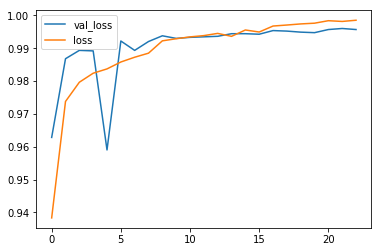

In [14]:
plt.plot(hist.history['val_acc'], label='val_loss')
plt.plot(hist.history['acc'], label='loss')
plt.legend()

In [15]:
#model.save('gpyopt_mnist_99557.hdf5')